<h1 style="font-size: 36px;">Probabilités numériques - Nano Projet - Théo Jalabert</h1>

<p style="font-size: 30px;">
   Simulation des deltas d'options vanilles (Call & Put) pour différents prix d'exercice en utilisant les méthodes suivantes :
</<ul style="list-style-type: none;">
    <li style="font-size: 25px;">Calcul par la méthode de Monte Carlo classique</li>
    <li style="font-size: 25px;">Méthode par lot (Batch Method)</li>
    <li style="font-size: 25px;">Méthode du praticien (Practitioner's Method)</li>
    <li style="font-size: 25px;">Méthode adaptative (Adaptive Method)</li>
</ul>

<p></p>


L'objectif de ce nano-projet est d'estimer le prix d'une option vanille en utilisant différentes méthodes d'estimation dans le cadre du modèle de Black-Scholes. 
Le prix de l'actif sous-jacent est noté $S_{T}^{x}$, et sa dynamique sous la probabilité risque neutre $\mathbb{Q}$ est donnée par : $$dS_t^x = S_t^x ( r \, dt + \sigma \, dW_t)$$
où :
- $W_t$ est un mouvement brownien sous $\mathbb{Q}$,
- $r \geq 0$ est le taux sans risque,
- $\sigma > 0$ est la volatilité,
- $S_0^x = x > 0$ représente la valeur initiale de l'actif sous-jacent.

### 1. Création des fonctions et méthodes de base

#### 1.1. Fonctions de base

In [ ]:
# Importation des bibliothèques essentielles
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import time

Nous initialisons l'espace et nous générons les processus aléatoires nécessaires. Ensuite, nous créons une fonction permettant de générer les trajectoires browniennes.

In [25]:
from numpy.random import default_rng, SeedSequence

# Initialisation d'une graine aléatoire
seed_sequence = SeedSequence()  
rng = default_rng(seed_sequence)  # Génération de séquences aléatoires

def brownian_simulation(paths : int, times : np.ndarray, increments : bool=False, rng: np.random.Generator = None) -> np.ndarray : 
    if rng is None : 
        rng = np.random.default_rng() # Crée une graine et un algorithme associé si aucun n'est fourni

    # Nous trions la discrétisation de notre temps et calculons la longueur à chaque instant pour déterminer la variance de nos processus gaussiens
    np.sort(times)
    time_lenght = np.diff(times).astype(np.float32)

    # Nous calculons les points 
    brownian_paths = (np.sqrt(time_lenght)*rng.standard_normal((paths, len(time_lenght)))).astype(np.float32)
    
    # Ne retourne que les incréments entre chaque point
    if increments : 
        return brownian_paths.ravel()
        
    # Retourne sinon les trajectoires du mouvement brownien, nécessitant la somme des incréments à partir de 0
    paths = np.hstack([np.zeros((paths,1)).astype(np.float32), np.cumsum(brownian_paths, axis=1)])
    
    return paths      

La dynamique de notre actif sous-jacent sous la probabilité neutre au risque $\mathbb Q$ est donnée par :

$$S_t = S_0e^{(r - \frac{\sigma^2}{2})t + \sigma W_t}$$

où : 
- $W_t$ est un mouvement brownien sous $\mathbb{Q}$, 
- $r \geq 0$ est le taux sans risque, 
- $\sigma > 0$ est la volatilité, 
- et $S_0^x = x > 0$ est la valeur initiale de l’actif sous-jacent.

Nous définissons donc une fonction pour générer le prix de notre actif sous-jacent à l’instant $T$, qui peut également fournir le même brownien utilisé pour obtenir nos prix, car cela sera utile plus tard.

In [26]:
# Certaines de nos méthodes nécessitent de générer deux séries de prix afin de réduire la variance
# Comme nous aurons besoin de générer deux séries de prix à partir du même espace probabiliste, 
# nous ajoutons une option pour choisir entre une ou deux séries de prix
# Nous pourrions également avoir besoin de retourner la trajectoire brownienne générée afin de calculer notre option 
# comme le montrera la formule fermée suivante pour les prix des options

def underlying_prices(S0, r, sigma, T, n, double_prices_series=False, brownian_constructor=False):
    brownian_paths = brownian_simulation(paths=n, times=np.array([0.0, T]), increments=True, rng=rng)

    # En raison de la symétrie du mouvement brownien géométrique, nous utilisons la valeur négative 
    # du mouvement brownien généré pour obtenir notre deuxième série de prix
    if double_prices_series:
        S1 = S0 * np.exp((r - 0.5 * (sigma**2)) * T + sigma * brownian_paths)
        brownian_paths = -brownian_paths
        S2 = S0 * np.exp((r - 0.5 * (sigma**2)) * T + sigma * brownian_paths)
        if brownian_constructor:
            return S1, S2, -brownian_paths
        else:
            return S1, S2
    else:
        S = S0 * np.exp((r - 0.5 * (sigma**2)) * T + sigma * brownian_paths)
        if brownian_constructor:
            return S, brownian_paths
        else:
            return S

Le payoff de l’option call à $T$ est donné par :

$$
\Pi_T^{\text{Call(T,K)}}(S_T^x) = (S_T^x-K)_+
$$

et celui de l’option put à $T$ est donné par :

$$
\Pi_T^{\text{Put(T,K)}}(S_T^x) = (K-S_T^x)_+
$$

Leurs dérivées sont les suivantes :

$$
\frac{d}{dS_T^{x}}(\Pi_T^{\text{Call(T,K)}}(S_T^x)) = \mathbf{1}_{{S_T^x \geq K}}
$$

$$
\frac{d}{dS_T^{x}}(\Pi_T^{\text{Put(T,K)}}(S_T^x)) = -\mathbf{1}_{{S_T^x \leq K}}
$$

Nous définissons donc des fonctions qui reproduisent ces payoffs.

In [27]:
def payoff_call (S, K) : return np.maximum(S-K,0)

def payoff_put (S, K) : return np.maximum(K-S,0)

def derivative_payoff_call (S,K) : return np.where(S > K, 1, 0)

def derivative_payoff_put(S,K) : return np.where(K > S, -1, 0)

Le prix d’un call à l’instant $t=0$ est donné par la formule de Black & Scholes :

$$C_0(T,K) = S_0\mathcal{N}(d_+) - Ke^{-rT}\mathcal{N}(d_-)$$

et le prix d’un put équivalent est donné par :

$$P_0(T,K) = C_0(T,K) - S_0 + Ke^{-rT}$$

où $\mathcal{N}$ est la fonction de répartition cumulative (CDF) d’une variable normale standard avec :

$$d_+ = \frac{\log\left(\frac{x}{Ke^{-rT}}\right)+\frac{\sigma^2}{2}T}{\sigma\sqrt{T}}.$$

et

$$d_- = d_+ - {\sigma\sqrt{T}}$$

À partir de la formule fermée de Black & Scholes pour les prix des calls et puts, nous pouvons également dériver les deltas, c’est-à-dire les premières dérivées par rapport au sous-jacent de nos options vanilles :

$$\frac{d}{dS_0}(C_0(T,K)) = \delta_0^{Call} =\mathcal{N}(d_+)$$
$$\frac{d}{dS_0}(P_0(T,K)) = \delta_0^{Put}=  \mathcal{N}(d_+)-1$$

Nous définissons donc nos fonctions pour calculer les prix théoriques exacts des options vanilles ainsi que leurs deltas.

In [28]:
# Formule fermée de Black-Scholes
def call_price(S0, r, sigma, T, K, n):
    d1 = (np.log(S0 / (K * np.exp(-r * T))) + (sigma**2) * (T / 2)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * (np.exp(-r * T)) * norm.cdf(d2)
    return np.full(n, call_price).astype(np.float32)


# Utilisation de la parité Call-Put
def put_price(S0, r, sigma, T, K, n):
    return call_price(S0, r, sigma, T, K, n) - S0 + K * np.exp(-r * T)


def delta_call(S0, r, sigma, T, K):
    d1 = (np.log(S0 / (K * np.exp(-r * T))) + (sigma**2) * (T / 2)) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


# Utilisation de la parité Call-Put
def delta_put(S0, r, sigma, T, K):
    return delta_call(S0, r, sigma, T, K) - 1

En utilisant le fait que les fonctions de payoff des options call et put sont boréliennes et croissantes polynomialement, nous obtenons, grâce au lemme de Stein, les résultats suivants :

$$\delta_0^{Call} = e^{-rT}\mathbb{E}\left[(S_T^x-K)_+\frac{W_T}{x\sigma T}\right]$$
$$\delta_0^{Put} = e^{-rT}\mathbb{E}\left[(K-S_T^x)_+\frac{W_T}{x\sigma T}\right]$$

Nous appellerons cette quantité le delta brownien, que nous essayerons d’estimer via un **brownian_delta_estimator** (abrégé **b_d_e** dans le code).

De plus, en utilisant le fait que les fonctions de payoff des options call et put sont dérivables et ont une dérivée polynomialement croissante, nous obtenons les résultats suivants :

$$\delta_0^{Call} = e^{-rT}\mathbb{E}\left[\frac{d}{dS_T^{x}}((S_T^x-K)_+)\frac{S_T^x}{x}\right]= e^{-rT}\mathbb{E}\left[\mathbb{1}_{{S_T^x \geq K}}\frac{S_T^x}{x}\right]$$
$$\delta_0^{Put} = e^{-rT}\mathbb{E}\left[\frac{d}{dS_T^{x}}((K-S_T^x)_+)\frac{S_T^x}{x}\right] = e^{-rT}\mathbb{E}\left[-\mathbb{1}_{{S_T^x \leq K}}\frac{S_T^x}{x}\right]$$

Nous appellerons cette quantité le delta sous-jacent, que nous essayerons d’estimer via un **underlying_delta_estimator** (abrégé **y_d_e** dans le code).

Ainsi, nous obtenons les relations suivantes :


La formule fermée du delta du call est la suivante :

$$\delta_0^{Call} = e^{-rT}\mathbb{E}\left[\mathbb{1}_{{S_T^x \geq K}}\frac{S_T^x}{x}\right] = e^{-rT}\mathbb{E}\left[(S_T^x-K)_+\frac{W_T}{x\sigma T}\right]=\mathcal{N}(d_+)$$


La formule fermée du delta du put est la suivante :

$$\delta_0^{Put} = e^{-rT}\mathbb{E}\left[-\mathbb{1}_{{S_T^x \leq K}}\frac{S_T^x}{x}\right] = e^{-rT}\mathbb{E}\left[(K-S_T^x)_+\frac{W_T}{x\sigma T}\right]=\mathcal{N}(d_+)-1$$

Nous avons donc une formule fermée pour chaque delta et deux espérances que nous pouvons approximer en utilisant nos méthodes Monte Carlo.

Nous codons nos fonctions pour déterminer **brownian_delta_estimator** et **underlying_delta_estimator**.

In [29]:
# Une fois que nous sommes capables de générer nos prix et nos trajectoires browniennes, 
# nous devons calculer les estimations pour chaque méthode, réalisées à travers les fonctions suivantes :

def b_d_e_simulation(S0, S, W, K, T, sigma, r, payoff_function):
    # Estimation via delta brownien
    return np.exp(-r * T) * payoff_function(S, K) * W * (1 / (T * S0 * sigma))


def y_d_e_simulation(S0, S, W, K, T, sigma, r, payoff_function):
    # Estimation via delta sous-jacent
    S = S.astype(np.float32)
    return np.exp(-r * T) * payoff_function(S, K) * (S / S0)

Pendant la description et l’implémentation de chaque méthode, nous utiliserons la notation $X_k$ pour désigner la $k^{\text{ème}}$ simulation du delta de notre option.

Nous supposons que la suite $ (X_k)_{k=1}^n $ est i.i.d. pour tout $n \geq 0$.

### Les méthodes utilisées : 

#### 1.2. Monte-Carlo Classique

Nous effectuons d’abord une simulation de Monte Carlo “classique”, c’est-à-dire sans modification de notre estimateur. Cette méthode a une variance élevée, que nous chercherons à réduire par la suite dans ce nano-projet.

$$
\sqrt{n} \left( \overline{X}_n - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_X^2) \quad \text{lorsque } n \to +\infty,
$$

avec
$$
\overline{X_n} = \frac{1}{n}\sum_{k=1}^n{X_k} \quad \text{et} \quad m_X = \mathbb{E}[X_1] \quad \text{et} \quad \sigma_X^2 = \mathbb{V}[X_1],
$$

et par conséquent, si nous définissons notre erreur comme suit :
$$
\epsilon_n = \overline{X}_n - m_X,
$$

nous pouvons en déduire que :
$$
\epsilon_n \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_X^2}{n}\right).
$$

In [30]:
def MC_option_simulation(S, serie=False, nb_simu=1000, var=False):

    # Nous pouvons choisir de retourner la série cumulée de MC pour avoir une meilleure idée de la convergence en fonction du nombre de simulations
    if serie:

        # Nous extrayons un sous-ensemble de plusieurs processus MC (nb_simu) 
        # pour observer la convergence de la série
        # Une première tentative, plus rapide, a été réalisée avec cumsum. Cependant, 
        # l'approximation par itérations successives a donné des résultats faux avec n > 1M.
        # Une approche utilisant une simulation MC unique via une approche récursive,
        # plus lente mais plus précise, a donc été choisie.
        indices = np.linspace(0, len(S), nb_simu, dtype=int)
        serie = np.array([MC_option_simulation(S[:i], serie=False, nb_simu=nb_simu, var=var) for i in indices])
        return serie

    else:

        # Nous pouvons choisir de retourner la variance de notre erreur en plus du prix MC
        if var:
            return np.mean(S), (len(S) / ((len(S) - 1)) * ((np.sum(S**2) / len(S)) - np.mean(S)**2)) / len(S)
        else:
            return np.mean(S)

#### 1.3 Méthode par lot (Batch Method)

Cette approche utilise une méthode antithétique visant à réduire la variance de notre erreur et ainsi améliorer la qualité des prédictions.
Nous introduisons une variable de contrôle dynamique $\lambda$ telle que :

$$
X^{\lambda} = X - \lambda \Xi
$$

où $X$ et $X’$ suivent la même distribution, c’est-à-dire :

$$
\mathbb{E}[X] = \mathbb{E}[X’] = m_X, \quad \mathbb{V}[X] = \mathbb{V}[X’] = \sigma_X^2
$$

mais avec $\mathbb{V}[X - X’] > 0$, et $\Xi$ est définie comme suit :

$$
\Xi = X - X’
$$

La variance de $X^{\lambda}$ est minimisée lorsque :

$$
\lambda_{\min} = \frac{\text{cov}(X, \Xi)}{\text{Var}[\Xi]}
$$

#### Configuration de la simulation

La simulation est réalisée en utilisant :

$$
\overline{X}_n^\lambda = \frac{1}{n} \sum\limits_{k=1}^n X_k^\lambda
$$

ou de manière équivalente :

$$
\overline{X}_n^\lambda = \overline{X}_n + \overline{\lambda}_n \overline{\Xi}_n
$$

avec :

$$
\overline{\lambda}_n = \frac{\frac{1}{n} \sum\limits_{k=1}^n X_k (X_k - X_k’)}{\frac{1}{n} \sum\limits_{k=1}^n (X_k - X_k’)^2}
$$

et :

$$
\overline{\Xi}_n = \frac{1}{n} \sum\limits_{k=1}^n (X_k - X_k’)
$$

#### Comportement asymptotique

Nous avons la convergence asymptotique suivante :

$$
\sqrt{n} \left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_{\min}^2) \quad \text{lorsque } n \to +\infty
$$

ou de manière équivalente :

$$
\left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_{\min}^2}{n}\right) \quad \text{lorsque } n \to +\infty
$$

avec :

$$
\sigma_{\min}^2 \leq \sigma_X^2
$$

In [31]:
def Batch_approach(S1, S2, serie=False, nb_simu=1000, parameters=False, var=False): 

    # Implémentation de theta
    theta = S1 - S2    

    # Nous pouvons choisir de retourner la série cumulée pour avoir une meilleure idée de la convergence selon le nombre de simulations
    if serie: 
        # Nous extrayons un sous-ensemble de processus MC (nombre de simulations) pour observer la convergence de la série
        # Une première tentative rapide avec cumsum a donné des résultats inexacts pour n > 1M
        # Une approche récursive, plus lente mais plus précise, a donc été choisie
        indices = np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Batch_approach(S1[:i], S2[:i], serie=False, nb_simu=nb_simu, parameters=parameters, var=var) for i in indices])   
        return serie 

    else: 
        # Création du paramètre lambda Batch utilisé pour calculer le prix estimé
        param_lambda = np.mean(S1 * theta) / np.mean(theta**2)
        
        if parameters: 
            return param_lambda
        else: 
            # Calcul de la moyenne des payoffs simulés et de theta pour le prix Batch
            S1_mean = np.mean(S1)
            theta_mean = np.mean(S1 - S2)
            
            if var: 
                # Calcul de la variance de l'erreur
                indices = np.arange(1, len(theta) + 1, dtype=np.float32)
                partial_theta_squared = theta**2
                cumulative_theta_squared = np.cumsum(partial_theta_squared)
                averaged_theta_squared = cumulative_theta_squared / indices
                epsilon = 1e-10
                averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)
                partial_lambda1 = S1 * theta
                cumulative_lambda1 = np.cumsum(partial_lambda1)
                averaged_lambda1 = cumulative_lambda1 / indices
                lambda1 = averaged_lambda1 / averaged_theta_squared

                return S1_mean - param_lambda * theta_mean, (len(S1) / (len(S1) - 1)) * ((np.sum(((S1 - lambda1 * theta)**2) / len(S1)) - np.mean(S1 - lambda1 * theta)**2)) / len(S1)
            else: 
                return S1_mean - param_lambda * theta_mean

#### 1.4. La méthode du practicien (Practitioner's Method)

En pratique, nous avons la relation suivante :

$$
\overline{X}_n^{\lambda{\min}} = \overline{X}_n - \lambda_{\min} \overline{\Xi}_n
$$

En prenant l’espérance des deux côtés :

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = \mathbb{E}[\overline{X}_n] - \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

i.e.

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = m - \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

Cependant, en pratique, $\mathbb{E}[\lambda_{\min} \overline{\Xi}_n] \neq 0$.

Pour résoudre ce problème, nous utilisons une approche appelée le “coin du praticien” :

Nous fixons n{\prime} < n et simulons $(X_k, X_k’)_{k=1}^{n’}$. Nous construisons $\hat{\lambda}$ tel que :

$$
\hat{\lambda}_{n’} = \frac{\frac{1}{n’} \sum\limits_{k=1}^{n’} X_k (X_k - X_k’)}{\frac{1}{n’} \sum\limits_{k=1}^{n’} (X_k - X_k’)^2}
$$

Puis nous construisons notre estimateur $\overline{X}_{n-n’+1}$ :

$$
\overline{X}_{n-n’} = \frac{1}{n-n’} \sum\limits_{k=n^{’}+1}^{n} X_k + \frac{\hat{\lambda}_{n’}}{n-n’} \sum\limits_{k=n^{’}+1}^{n} \Xi_k
$$

Nous obtenons alors :

$$
\mathbb{E}[\overline{X}_{n-n’}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n’} \overline{\Xi}_{n-n’}]
$$

ou équivalemment :

$$
\mathbb{E}[\overline{X}_{n-n’}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n’}] \cdot \mathbb{E}[\overline{\Xi}_{n-n’}]
$$

Avec :

$$
\mathbb{E}[\overline{\Xi}_{n-n’}] = 0
$$

Ainsi, l’estimateur $\overline{X}_{n-n’}^{\lambda_{\min}}$ est sans biais.

In [32]:
def Practitioner_corner(S1, S2, serie=False, nb_simu=1000, var=False): 
    
    if serie:
        indices = np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Practitioner_corner(S1[:i], S2[:i], serie=False, nb_simu=nb_simu, var=var) for i in indices])   
        return serie 
    
    else: 
        n_1 = int(np.floor(0.15 * len(S1)))
        n_2 = len(S1) - n_1

        theta = S1 - S2
        lambda_practitioner = np.mean(S1[:n_1] * theta[:n_1]) / np.mean(theta[:n_1] ** 2)
        S1_mean = np.mean(S1[n_1+1:])
        theta_mean = np.mean(theta[n_1+1:])

        if var: 
            return S1_mean - lambda_practitioner * theta_mean, (len(S1[n_1:]) / (len(S1[n_1:]) - 1)) * ((np.sum(((S1[n_1:] - lambda_practitioner * theta[n_1:])**2) / len(S1[n_1:])) - np.mean(S1[n_1:] - lambda_practitioner * theta[n_1:])**2)) / len(S1[n_1:])
        else: 
            return S1_mean - lambda_practitioner * theta_mean

#### 1.5. Méthode adaptative (Adpative Method)

Une autre approche existe, appelée approche adaptative, pour résoudre ce problème de biais sans diviser l’effort comme dans le “coin du praticien”.

Nous définissons :

$$
\tilde{X}_k = X_k - \tilde{\lambda}_{k-1} \Xi_k
$$

où :

$$
\tilde{\lambda}_{k} = \big((-k) \lor \lambda_k\big) \land k
$$

avec $\lambda_k$ le paramètre provenant de notre approche par lot (Batch approach).

Notre estimateur est alors calculé comme suit :

$$
\overline{\tilde{X}}_n = \overline{X}_n - \frac{1}{n} \sum\limits_{k=1}^{n} \tilde{\lambda}_{k-1} \Xi_k
$$

ou :

$$
\overline{\tilde{X}}_n = \overline{X}_n - \tilde{\lambda}_{k-1} \overline{\Xi}_k
$$

In [33]:
def Adaptative_approach(S1, S2, serie=False, nb_simu=1000, var=False): 

    # Implémentation de theta
    theta = S1 - S2

    # Nous pouvons choisir de retourner la série cumulée pour avoir une meilleure idée de la convergence selon le nombre de simulations
    if serie:
        
        # Nous extrayons un sous-ensemble de processus MC (nombre de simulations) pour observer la convergence de la série
        # Une première tentative rapide avec cumsum a donné des résultats inexacts pour n > 1M
        # Une approche récursive, plus lente mais plus précise, a donc été choisie
        indices = np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Adaptative_approach(S1[:i], S2[:i], serie=False, nb_simu=nb_simu, var=var) for i in indices])   
        return serie 
     
    else: 

        # Calcul des payoffs simulés, de la moyenne de theta et du paramètre lambda, utilisés pour l'approche adaptative
        S1_mean = np.mean(S1)
        theta_mean = np.mean(S1 - S2)
        lambda_adaptative_one_price = min(max((np.mean(S1[:-1] * theta[:-1]) / np.mean(theta[:-1] ** 2)), -(len(S1) - 1)), len(S1) - 1)

        if var: 
            # Création de l'indice pour calculer les moyennes cumulées
            indices = np.arange(1, len(theta) + 1, dtype=np.float32)

            # Calcul des moyennes cumulées de theta²
            partial_theta_squared = theta**2
            cumulative_theta_squared = np.cumsum(partial_theta_squared)
            averaged_theta_squared = cumulative_theta_squared / indices

            # Sécurité pour éviter la division par zéro
            epsilon = 1e-10
            averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)

            # Calcul des lambda cumulés
            partial_lambda1 = S1 * theta
            cumulative_lambda1 = np.cumsum(partial_lambda1)
            averaged_lambda1 = cumulative_lambda1 / indices
            lambda1 = averaged_lambda1 / averaged_theta_squared
            
            # Application de la formule pour obtenir le paramètre adaptatif
            lambda_adaptative_no_shifted = np.maximum(-indices, np.minimum(lambda1, indices))
            
            # Décalage pour utiliser lambda_{k-1} dans le calcul récurrent
            lambda_adaptative = np.concatenate(([0], lambda_adaptative_no_shifted[:-1]))
            
            # Retourne le prix adaptatif et la variance de l'erreur sur la série cumulée
            return S1_mean - lambda_adaptative_one_price * theta_mean, (len(S1) / (len(S1) - 1)) * ((np.sum(((S1 - lambda1 * theta)**2) / len(S1)) - np.mean(S1 - lambda1 * theta)**2)) / len(S1)
            
        else: 
            # Retourne uniquement le prix adaptatif
            return S1_mean - lambda_adaptative_one_price * theta_mean

### 2. Fonction pour afficher les résultats

#### 2.1. Fonction pour afficher un DataFrame pandas contenant nos résultats

In [34]:
# Fonction pour afficher les résultats en fonction du nombre de simulations ainsi que de la variance
def print_results_panda(S0, r, T, K, sigma, estimator_function, prix_option, payoff_function, n_values, series=False, title=""): 
    
    beginning = time.time()

    # Nous calculons les prix simulés
    S1, S2, W = underlying_prices(S0, r, sigma, T, max(n_values), double_prices_series=True, brownian_constructor=True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    W = W.astype(np.float32)

    # Nous calculons une seule fois nos estimations pour chaque estimateur et chaque méthode
    S1_complete = [[] for i in range(len(estimator_function))]
    S2_complete = [[] for i in range(len(estimator_function))]
    index = 0
    for estimator in estimator_function: 
        for f in payoff_function[index]: 
            S1_complete[index].append(estimator(S0, S1, W, K, T, sigma, r, f))
            S2_complete[index].append(estimator(S0, S2, -W, K, T, sigma, r, f))
        index += 1
 
    end = time.time()
    execution_time = end - beginning

    # Nous mesurons le temps d'exécution pour identifier quelle routine est la plus lente
    print(f"Temps pour générer {max(n_values):,} prix et {max(n_values) * len(estimator_function) * len(payoff_function):,} payoffs associés : {execution_time:.2f} secondes")
        
    for j in range(len(prix_option)): 
        
        BS_price = prix_option[j](S0, r, sigma, T, K)

        # Préparation des tableaux numpy pour stocker les données
        errors_mc = np.array([])
        errors_batch = np.array([])
        errors_practitioner = np.array([])
        errors_adaptative = np.array([]) 
        
        vars_mc = np.array([])
        vars_batch = np.array([])
        vars_practitioner = np.array([])
        vars_adaptative = np.array([]) 

        nb_simu = np.array([]) 
        estimator_name = np.array([])

        times = np.array([]) 
        
        for n in n_values:
            for i in range(len(estimator_function)):

                S1 = np.asarray(S1_complete[i][j][:n])
                S2 = np.asarray(S2_complete[i][j][:n])

                # Pour chaque estimateur et méthode, nous calculons le prix, la variance et nous stockons l'erreur relative au prix BS et à la variance
                beginning = time.time()
                
                # Méthode Monte Carlo classique
                mc_price, var_mc = MC_option_simulation(S1, serie=series, var=True)
                errors_mc = np.append(errors_mc, np.abs(mc_price - BS_price))
                vars_mc = np.append(vars_mc, var_mc)
        
                # Méthode Batch
                batch_price, var_batch = Batch_approach(S1, S2, serie=series, var=True)
                errors_batch = np.append(errors_batch, np.abs(batch_price - BS_price))
                vars_batch = np.append(vars_batch, var_batch)
        
                # Méthode du praticien
                practitioner_price, var_practitioner = Practitioner_corner(S1, S2, serie=series, var=True)
                errors_practitioner = np.append(errors_practitioner, np.abs(practitioner_price - BS_price))
                vars_practitioner = np.append(vars_practitioner, var_practitioner)
        
                # Méthode adaptative
                adaptative_price, var_adaptative = Adaptative_approach(S1, S2, serie=series, var=True)
                errors_adaptative = np.append(errors_adaptative, np.abs(adaptative_price - BS_price))
                vars_adaptative = np.append(vars_adaptative, var_adaptative)

                nb_simu = np.append(nb_simu, n)
            
                estimator_name = np.append(estimator_name, ''.join(estimator_function[i].__name__.split('_')[:3]).upper())

                # Calcul du temps d'exécution
                end = time.time() 
                execution_time = end - beginning
                times = np.append(times, round(execution_time, 4))

            # Nous comparons également les deux estimateurs entre eux en calculant le rapport
            if len(estimator_function) == 2: 
                idx_numerator = -2
                idx_denominator = -1
                errors_mc = np.append(errors_mc, round(errors_mc[idx_numerator] / errors_mc[idx_denominator], 4))
                vars_mc = np.append(vars_mc, round(vars_mc[idx_numerator] / vars_mc[idx_denominator], 4))
                
                errors_batch = np.append(errors_batch, round(errors_batch[idx_numerator] / errors_batch[idx_denominator], 4))
                vars_batch = np.append(vars_batch, round(vars_batch[idx_numerator] / vars_batch[idx_denominator], 4))

                errors_practitioner = np.append(errors_practitioner, round(errors_practitioner[idx_numerator] / errors_practitioner[idx_denominator], 4))
                vars_practitioner = np.append(vars_practitioner, round(vars_practitioner[idx_numerator] / vars_practitioner[idx_denominator], 4))

                errors_adaptative = np.append(errors_adaptative, round(errors_adaptative[idx_numerator] / errors_adaptative[idx_denominator], 4))
                vars_adaptative = np.append(vars_adaptative, round(vars_adaptative[idx_numerator] / vars_adaptative[idx_denominator], 4))

                times = np.append(times, "")
                nb_simu = np.append(nb_simu, n)
                estimator_name = np.append(estimator_name, estimator_name[idx_numerator] + " \ " +  estimator_name[idx_denominator])

        # Création d'un DataFrame pour afficher les résultats
        results = pd.DataFrame({
            'Nb simulation': [f"{x:,}" for x in nb_simu],
            'Estimator': estimator_name,
            'Time computation 4 estimators': times,
            'Error Classic MC': errors_mc,
            'Error Batch approach': errors_batch,
            'Error Practitioner approach': errors_practitioner,
            'Error Adaptive approach': errors_adaptative,
            'Var error Classic MC': [f"{float(x):.6e}" if x != "" else "" for x in vars_mc],
            'Var error Batch approach': [f"{float(x):.6e}" if x != "" else "" for x in vars_batch],
            'Var error Practitioner approach': [f"{float(x):.6e}" if x != "" else "" for x in vars_practitioner],
            'Var error MC Adaptive approach': [f"{float(x):.6e}" if x != "" else "" for x in vars_adaptative]})

        # Regroupement des lignes avec le même nombre de simulations
        results['Nb simulation'] = results['Nb simulation'].mask(results['Nb simulation'].duplicated(), '')

        # Ajout et centrage d'un titre au DataFrame avec HTML
        html_template = f"""
        <div style="display: flex; flex-direction: column; align-items: center;">
            <div style="text-align: center; font-size: 20px; font-weight: bold; margin-bottom: 10px;">
                {title[j]}
            </div>
            {results.to_html(index=False)}
        </div>
        """
        
        display(HTML(html_template))

<>:104: SyntaxWarning: invalid escape sequence '\ '
<>:104: SyntaxWarning: invalid escape sequence '\ '
/var/folders/0b/_dxm0fdx5n30kf1v5lkj7y9w0000gn/T/ipykernel_78736/4024679156.py:104: SyntaxWarning: invalid escape sequence '\ '
  estimator_name = np.append(estimator_name, estimator_name[idx_numerator] + " \ " +  estimator_name[idx_denominator])


#### 2.2. Fonction pour afficher et analyser la vitesse de convergence des erreurs en fonction du nombre de simulations

In [49]:
# Cette sous-fonction a pour objectif de calculer les erreurs pour alimenter la fonction de traçage ci-dessous
def generate_data_convergence_error_according_to_n(K, S1, S2, BS_price, option_type, estimator_function, nb_simu_wanted): 

    # Nous calculons les prix simulés
    
    mc_price = MC_option_simulation(S1, serie=True, nb_simu=nb_simu_wanted)
    error_mc = np.abs(mc_price - BS_price)
    
    batch_price = Batch_approach(S1, S2, serie=True, nb_simu=nb_simu_wanted)
    batch_errors = np.abs(batch_price - BS_price)

    practitioner_price = Practitioner_corner(S1, S2, serie=True, nb_simu=nb_simu_wanted)
    practitioner_errors = np.abs(practitioner_price - BS_price)
   
    adaptative_price = Adaptative_approach(S1, S2, serie=True, nb_simu=nb_simu_wanted)
    adaptative_errors = np.abs(adaptative_price - BS_price)

    # Nous convertissons nos tableaux numpy en liste pour faciliter le traçage avec matplotlib
    data = [arr for arr in [error_mc, batch_errors, practitioner_errors, adaptative_errors]]
    data = [[f"{option_type.__name__.replace('_', ' ').title()}", K, ''.join(estimator_function.__name__.split('_')[:3]).upper()]] + data
    
    return data

# Cette fonction trace un échantillon des méthodes Monte Carlo entre 0 et le nombre de simulations donné pour montrer la vitesse de convergence
# Pour avoir une référence, le taux CV de 1 / sqrt(n) est également tracé
# Nous pouvons décider du nombre de points que nous souhaitons générer
# Fonction classique de traçage qui peut s'adapter dynamiquement au nombre de "séries de données" données
# Elle produira autant de graphiques que de "séries de données", avec un maximum de deux graphiques par ligne
def print_data_convergence_error_according_to_n(S0, r, sigma, T, K, n, estimator_function, option_type, payoff_function, nb_simu_wanted=1000, zoom=0): 
    
    datas = []

    # Simulation des prix
    beginning1 = time.time() 
    S1, S2, W1 = underlying_prices(S0, r, sigma, T, n, double_prices_series=True, brownian_constructor=True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    W1 = W1.astype(np.float32)
    W2 = -W1
    end1 = time.time()
    execution_time1 = end1 - beginning1

    # Calcul des erreurs
    beginning2 = time.time()

    for K_i in K: 
        for i in range(len(option_type)): 
            data = []
            for j in range(len(estimator_function)): 
                
                # Nous calculons les payoffs actualisés selon la fonction de payoff demandée
                # Nous ne pouvons pas le faire au début pour toutes les données en raison des différents strikes étudiés
                S1_bis = estimator_function[j](S0, S1, W1, K_i, T, sigma, r, payoff_function[j][i]) 
                S2_bis = estimator_function[j](S0, S2, W2, K_i, T, sigma, r, payoff_function[j][i])
                
                # Nous calculons la valeur de référence à l'aide de la formule fermée de Black-Scholes
                BS_price = prix_option[i](S0, r, sigma, T, K_i)

                # Nous générons nos séries d'erreurs à tracer selon chaque type d'option à afficher
                # Pour un résultat rapide mais moins précis, nous pouvons calculer seulement quelques nb_simu_wanted ou, au contraire, l'augmenter
                data.append(generate_data_convergence_error_according_to_n(K_i, S1_bis, S2_bis, BS_price, option_type[i], estimator_function[j], nb_simu_wanted))
            datas.append(data)

    end2 = time.time() 
    execution_time2 = end2 - beginning2

    # Adapter dynamiquement le nombre de graphiques à produire avec un maximum de 2 par ligne
    num_graphs = len(datas) 
    num_cols = 2                 
    num_rows = (num_graphs + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
    axes = axes.ravel()

    # Nous traçons nos données et chronométrons également cette étape (la principale source de temps d'exécution)
    beginning3 = time.time() 

    # Nous introduisons une option de zoom pour examiner de plus près la convergence
    # En effet, le taux CV est très rapide près de 0 et devient plus lent par la suite, rendant les graphiques moins lisibles
    # Si zoom = 15%, nous excluons les 15% premières valeurs
    zoom_index = int(zoom * nb_simu_wanted)
    n_values = np.linspace(0, len(S1), nb_simu_wanted, dtype=int)
    n_values_zoomed = n_values[zoom_index:]
    n_values_sqrt = n_values_zoomed
    if zoom == 0: 
        n_values_sqrt[0] = 1
    inverse_sqrt_n_values = 1 / np.sqrt(n_values_sqrt)

    for idx, dataset in enumerate(datas):
        ax = axes[idx]
        plot_data = [
            
            # Stocker les données et labels pour le tracé
            {"data": dataset[0][1][zoom_index:], "label": f"{dataset[0][0][2]} Monte Carlo Simulation", "color": "lightskyblue"},
            {"data": dataset[0][2][zoom_index:], "label": f"{dataset[0][0][2]} Batch Method", "color": "cornflowerblue"},
            {"data": dataset[0][3][zoom_index:], "label":  f"{dataset[0][0][2]} Practitioner Method", "color": "royalblue"},
            {"data": dataset[0][4][zoom_index:], "label":  f"{dataset[0][0][2]} Adaptive Method", "color": "navy"},

            {"data": dataset[1][1][zoom_index:], "label":  f"{dataset[1][0][2]} Monte Carlo Simulation", "color": "lightcoral"},
            {"data": dataset[1][2][zoom_index:], "label": f"{dataset[1][0][2]} Batch Method", "color": "indianred"},
            {"data": dataset[1][3][zoom_index:], "label": f"{dataset[1][0][2]} Practitioner Method", "color": "firebrick"},
            {"data": dataset[1][4][zoom_index:], "label": f"{dataset[1][0][2]} Adaptive Method", "color": "darkred"},
            
            # Référence CV 1 / sqrt(n)
            {"data": inverse_sqrt_n_values, "label": r"$\frac{1}{\sqrt{n}}$", "color": "black", "linestyle": "--"}]

        # Tracer les données
        for entry in plot_data:
            ax.plot(
                n_values_zoomed,
                entry["data"],  
                '-',
                label=entry["label"],
                color=entry["color"]
            )

        # Légende des graphiques
        ax.set_title(f"Erreur de pricing pour {dataset[0][0][0]} selon le nombre \n de simulations avec K = {dataset[0][0][1]}", fontsize=10)
        ax.set_xlabel("Nombre de simulations (n)")
        ax.set_ylabel(f"Erreur de pricing pour {dataset[0][0]}")
        ax.legend()
        ax.grid(True)

    # Supprimer les axes inutilisés
    for idx in range(len(datas), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    end3 = time.time() 
    execution_time3 = end3 - beginning3

    # Imprimer les résultats des temps d'exécution
    print(f"Temps de génération de {n:,} prix : {execution_time1:.2f} secondes")
    print(f"Temps de calcul des séries d'estimateurs pour chaque K et chaque fonction de payoff : {execution_time2:.2f} secondes")
    print(f"Temps de traçage : {execution_time3:.2f} secondes")

#### 2.3. Fonction pour afficher l’erreur d’approximation pour différents strikes et nombres de simulations

In [50]:
# Pour changer un peu, nous transformons notre fonction de tracé en sous-fonction
# Fonction classique de tracé
def graphe_result(strikes, prices, n, option_type): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Graphique pour afficher l'approximation du prix (ax1) et l'erreur par rapport au prix Black-Scholes (ax2)
    
    ax1.plot(strikes, prices[1], '-', color='Black', label='Black-Scholes')
    ax1.plot(strikes, prices[2], '-', color='lightskyblue', label=f"{prices[0][0]} Monte Carlo Simulation")
    ax1.plot(strikes, prices[3], '-', color='cornflowerblue', label=f"{prices[0][0]} Batch Method")
    ax1.plot(strikes, prices[4], '-', color='royalblue', label=f"{prices[0][0]} Practitioner Method")
    ax1.plot(strikes, prices[5], '-', color='navy', label=f"{prices[0][0]} Adaptive Method")
    ax1.plot(strikes, prices[6], '-', color='lightcoral', label=f"{prices[0][1]} Monte Carlo Simulation")
    ax1.plot(strikes, prices[7], '-', color='indianred', label=f"{prices[0][1]} Batch Method")
    ax1.plot(strikes, prices[8], '-', color='firebrick', label=f"{prices[0][1]} Practitioner Method")
    ax1.plot(strikes, prices[9], '-', color='darkred', label=f"{prices[0][1]} Adaptive Method")

    # Légende des graphiques
    ax1.set_title(f"Prix de l'option {option_type} en fonction de K ({n:,} simulations)", fontsize=10)
    ax1.set_xlabel("Strike (K)")
    ax1.set_ylabel(f"Prix de l'option {option_type}")
    ax1.legend()
    
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[2])], '-', color='lightskyblue', label=f'Différence {prices[0][0]} avec Monte Carlo Simulation')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[3])], '-', color='cornflowerblue', label=f'Différence {prices[0][0]} avec Batch Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[4])], '-', color='royalblue', label=f'Différence {prices[0][0]} avec Practitioner Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[5])], '-', color='navy', label=f'Différence {prices[0][0]} avec Adaptive Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[6])], '-', color='lightcoral', label=f'Différence {prices[0][1]} avec Monte Carlo Simulation')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[7])], '-', color='indianred', label=f'Différence {prices[0][1]} avec Batch Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[8])], '-', color='firebrick', label=f'Différence {prices[0][1]} avec Practitioner Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[9])], '-', color='darkred', label=f'Différence {prices[0][1]} avec Adaptive Method')

    # Légende des graphiques
    ax2.set_title(f"Differences des prix de l'option {option_type} avec Black-Scholes \npour chaque méthode ({n:,} simulations)", fontsize=10)
    ax2.set_xlabel("Strike (K)")
    ax2.set_ylabel(f"Differences sur le prix de l'option {option_type}")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Cette fonction génère les données des prix et des erreurs pour plusieurs strikes pour un nombre donné de simulations, puis appelle la fonction de tracé
def plot_result(S0, r, sigma, T, strikes, estimator_function, number_simulations, option_type, payoff_function): 

    # Nous chronométrons la vitesse de nos processus d'estimation
    beginning = time.time() 
    
    # Simulation des prix
    S1, W1 = underlying_prices(S0, r, sigma, T, n, brownian_constructor=True)
    S1.astype(np.float32), W1.astype(np.float32)
    S2, W2 = underlying_prices(S0, r, sigma, T, n, brownian_constructor=True)
    S2.astype(np.float32), W2.astype(np.float32)

    for i in range(len(number_simulations)): 
        
        # Création de notre structure de données pour recevoir nos prix et erreurs pour les cinq méthodes (formule fermée BS et quatre méthodes Monte Carlo)
        prices = [[[] for _ in range(2 + 4 * len(estimator_function))] for _ in range(len(option_type))]

        # Comme avant, nous adaptons le code à la structure de chaque indicateur qui utilise sa propre fonction de payoff
        # Nous ajoutons deux cas dans nos listes : un pour le nom de l'indicateur afin de les distinguer sur le graphique, et l'autre pour le prix BS
        for j in range(len(option_type)): 
            for K in strikes: 
                prices[j][0] = []
                prices[j][1].append(prix_option[j](S0, r, sigma, T, K))
                for k in range(len(estimator_function)): 
                    S1_bis = estimator_function[k](S0, S1[:number_simulations[i]], W1[:number_simulations[i]], K, T, sigma, r, payoff_function[k][j])
                    S2_bis = estimator_function[k](S0, S2[:number_simulations[i]], W2[:number_simulations[i]], K, T, sigma, r, payoff_function[k][j])

                    # Travail pour rendre le nom de l'indicateur lisible
                    prices[j][0].append(''.join(estimator_function[k].__name__.split('_')[:3]).upper())

                    # Nous stockons les prix de tous nos indicateurs dans les mêmes listes
                    prices[j][2 + k * 4].append(MC_option_simulation(S1_bis))
                    prices[j][3 + k * 4].append(Batch_approach(S1_bis, S2_bis))
                    prices[j][4 + k * 4].append(Practitioner_corner(S1_bis, S2_bis))
                    prices[j][5 + k * 4].append(Adaptative_approach(S1_bis, S2_bis))

            end = time.time() 
            execution_time = end - beginning
    
            # Nous traçons le temps qu'il nous a fallu
            graphe_result(strikes, prices[j], number_simulations[i], option_type[j].__name__.replace('_', ' ').title())
            print(f"Temps d'exécution pour n égal à {number_simulations[i]:,}: {execution_time:.2f} secondes")

### 3. Affichage des résultats

#### 3.1. Analyse numérique

In [51]:
S0_df = 100    # Prix initial de l'actif sous-jacent
r_df = 0.05     # Taux d'intérêt sans risque
sigma_df = 0.2  # Volatilité
T_df = 8        # Maturité
K_df = 100      # Prix d'exercice (Strike)
n_values_df = np.array([100000, 1000000, 10000000])  # Nombre de simulations pour les méthodes Monte Carlo
estimator_function_df = [b_d_e_simulation, y_d_e_simulation]  # Fonctions d'estimation
prix_option_df = [delta_call, delta_put]  # Formules fermées pour le calcul des prix des options
payoff_function_df = [[payoff_call, payoff_put], [derivative_payoff_call, derivative_payoff_put]]  # Fonctions de payoff
title_df = [f'Table pour un {prix_option_df[i].__name__.split("_")[-1]} avec un delta de {np.round(prix_option_df[i](S0_df, r_df, sigma_df, T_df, K_df),7)}' for i in range(len(prix_option_df))]  # Titres

In [52]:
# Affichage des données pour observer la convergence des erreurs ainsi que la réduction de variance
# Permet également de comparer les différentes méthodes et les deux estimateurs (BDE et YDE)
beginning = time.time()  
print_results_panda(S0_df, r_df, T_df, K_df, sigma_df, estimator_function_df, prix_option_df, payoff_function_df, n_values_df, series=False, title=title_df)
end = time.time() 
execution_time = end - beginning
print(f"Temps d'exécution total : {execution_time:.2f} secondes")

Temps pour générer 10,000,000 prix et 40,000,000 payoffs associés : 0.50 secondes


Nb simulation,Estimator,Time computation 4 estimators,Error Classic MC,Error Batch approach,Error Practitioner approach,Error Adaptive approach,Var error Classic MC,Var error Batch approach,Var error Practitioner approach,Var error MC Adaptive approach
"100,000.0",BDE,0.0042,0.004209,0.000407,0.000349,0.000407,4.817522e-05,2.033385e-05,2.401967e-05,2.033385e-05
,YDE,0.0048,0.000661,0.000320,0.000485,0.000320,5.942441e-06,6.263137e-07,7.397530e-07,6.263137e-07
,BDE \ YDE,,6.365800,1.272100,0.719300,1.272100,8.107000e+00,3.246590e+01,3.246990e+01,3.246590e+01
"1,000,000.0",BDE,0.0481,0.004900,0.002919,0.003358,0.002919,4.897844e-06,2.066311e-06,2.436549e-06,2.066311e-06
,YDE,0.0667,0.001109,0.000473,0.000608,0.000473,5.940089e-07,6.327167e-08,7.455700e-08,6.327167e-08
,BDE \ YDE,,4.419600,6.168600,5.527500,6.168600,8.245400e+00,3.265780e+01,3.268040e+01,3.265780e+01
"10,000,000.0",BDE,0.4644,0.000273,0.000329,0.000111,0.000329,4.807007e-07,2.051258e-07,2.410069e-07,2.051258e-07
,YDE,0.7519,0.000314,0.000041,0.000002,0.000041,5.909069e-08,6.283864e-09,7.386825e-09,6.283864e-09
,BDE \ YDE,,0.868900,7.967100,69.408200,7.967100,8.135000e+00,3.264330e+01,3.262660e+01,3.264330e+01


Nb simulation,Estimator,Time computation 4 estimators,Error Classic MC,Error Batch approach,Error Practitioner approach,Error Adaptive approach,Var error Classic MC,Var error Batch approach,Var error Practitioner approach,Var error MC Adaptive approach
"100,000.0",BDE,0.0041,0.000206,0.000322,0.000118,0.000322,1.402927e-06,5.784522e-07,6.828842e-07,5.784522e-07
,YDE,0.0042,0.001065,0.000476,0.000542,0.000476,5.675617e-07,1.524689e-07,1.795175e-07,1.524689e-07
,BDE \ YDE,,0.193500,0.676200,0.216900,0.676200,2.471800e+00,3.793900e+00,3.804000e+00,3.793900e+00
"1,000,000.0",BDE,0.0576,0.000274,0.000485,0.000525,0.000485,1.424951e-07,5.845539e-08,6.889505e-08,5.845539e-08
,YDE,0.0744,0.000084,0.000005,0.000082,0.000005,5.649154e-08,1.527694e-08,1.797763e-08,1.527694e-08
,BDE \ YDE,,3.241100,95.784500,6.439700,95.787000,2.522400e+00,3.826400e+00,3.832300e+00,3.826400e+00
"10,000,000.0",BDE,0.4338,0.000222,0.000092,0.000063,0.000092,1.423367e-08,5.813205e-09,6.836157e-09,5.813205e-09
,YDE,0.8911,0.000112,0.000026,0.000034,0.000026,5.654250e-09,1.528400e-09,1.798263e-09,1.528400e-09
,BDE \ YDE,,1.981300,3.545400,1.848800,3.545400,2.517300e+00,3.803500e+00,3.801500e+00,3.803500e+00


Temps d'exécution total : 3.35 secondes


Nous avons les principales caractéristiques suivantes pour deux estimateurs :


- Croissance linéaire (jusqu’à un facteur scalaire) du temps de calcul en fonction du nombre de simulations réalisées.
- Convergence des erreurs vers 0 à mesure que le nombre de simulations augmente (plus lente pour des valeurs de $n$ élevées : le taux de convergence CV est de l’ordre de $O\left( \frac{1}{\sqrt{n}} \right) \to 0 \quad \text{lorsque} \quad n \to \infty$.
- Réduction de la variance des erreurs à mesure que le nombre de simulations augmente.
- Variance plus faible pour les méthodes utilisant des techniques de réduction de variance.
- Meilleure erreur asymptotique (plus faible) pour les méthodes sans biais utilisant la réduction de variance (Practitioner et Adaptive).
- Convergence asymptotique des résultats des méthodes Batch et Adaptive (pour $k$ grand : $\lambda_k \approx \lambda_{k-1}$ et  $\tilde{\lambda}_k = \lambda_k$ ).

Nous avons la confirmation que l'estimateur **YDE** est significativement meilleur que l'estimateur **BDE** en termes de :
- Erreur absolue
- Variance

De plus, le calcul de l’estimateur **YDE** nécessite uniquement une fonction indicatrice et le prix de l’actif sous-jacent, tandis que **BDE** requiert également l’observation du mouvement brownien et le calcul de la fonction de payoff de l’option évaluée. En plus d’être plus précis, l’estimateur **YDE** est légèrement plus rapide.

#### 3.2. Représentation graphique de la convergence des erreurs 

In [53]:
S0_CV = 100    # Prix initial de l'actif sous-jacent
r_CV = 0.05     # Taux d'intérêt sans risque
sigma_CV = 0.2  # Volatilité
T_CV = 8        # Maturité
K_CV = [70, 100, 130]  # Prix d'exercice (Strikes)
n_CV = 1000000  # Longueur maximale pour les simulations Monte Carlo
estimator_function_CV = [b_d_e_simulation, y_d_e_simulation]  # Fonctions d'estimation
option_type_CV = [delta_call, delta_put]  # Formules fermées pour le calcul des prix des options
nb_simu_wanted = 100  # Nombre de points de convergence Monte Carlo entre 0 et n_CV
payoff_function_CV = [[payoff_call, payoff_put], [derivative_payoff_call, derivative_payoff_put]]  # Fonctions de payoff

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


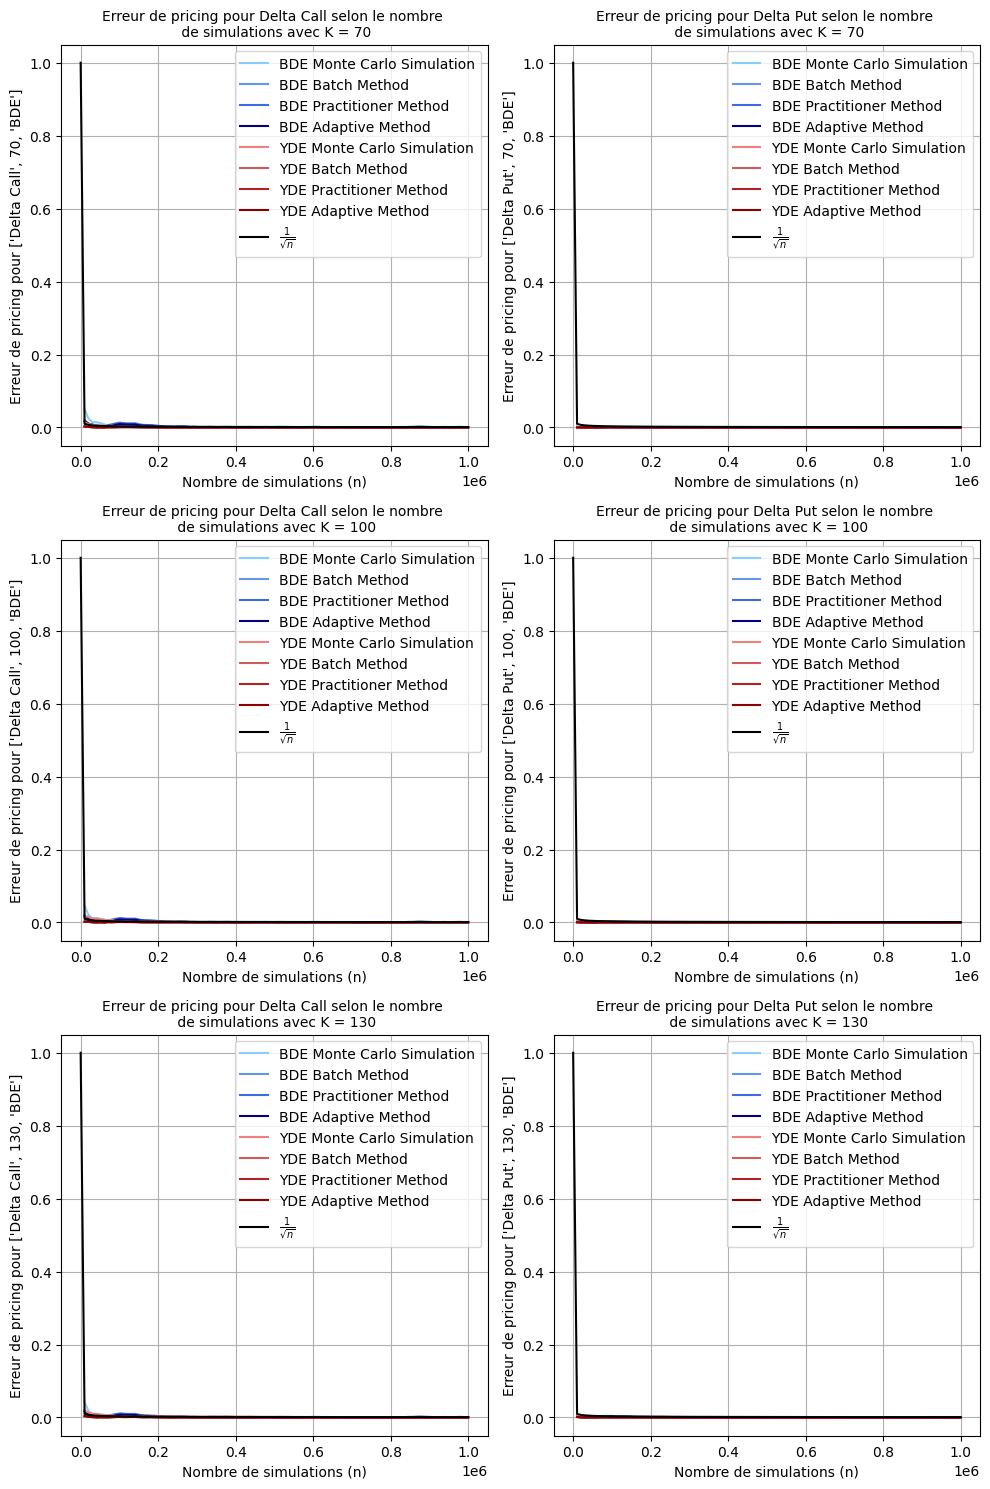

Temps de génération de 1,000,000 prix : 0.03 secondes
Temps de calcul des séries d'estimateurs pour chaque K et chaque fonction de payoff : 5.16 secondes
Temps de traçage : 0.53 secondes
Temps d'exécution total pour une série totale de 4,800 méthodes Monte Carlo : 6.09 secondes


In [59]:
# Nous traçons les graphiques pour comparer la convergence de chaque méthode et indicateur avec 1 / sqrt(n)
# Une première version naïve sans zoom (le graphique sera déformé par les premières valeurs)
beginning = time.time()
prix_option = prix_option_df
print_data_convergence_error_according_to_n(
    S0_CV, r_CV, sigma_CV, T_CV, K_CV, n_CV, estimator_function_CV, option_type_CV, payoff_function_CV, nb_simu_wanted, zoom=0
)
end = time.time() 
execution_time = end - beginning
print(f"Temps d'exécution total pour une série totale de {16 * len(K_CV) * nb_simu_wanted:,} méthodes Monte Carlo : {execution_time:.2f} secondes")

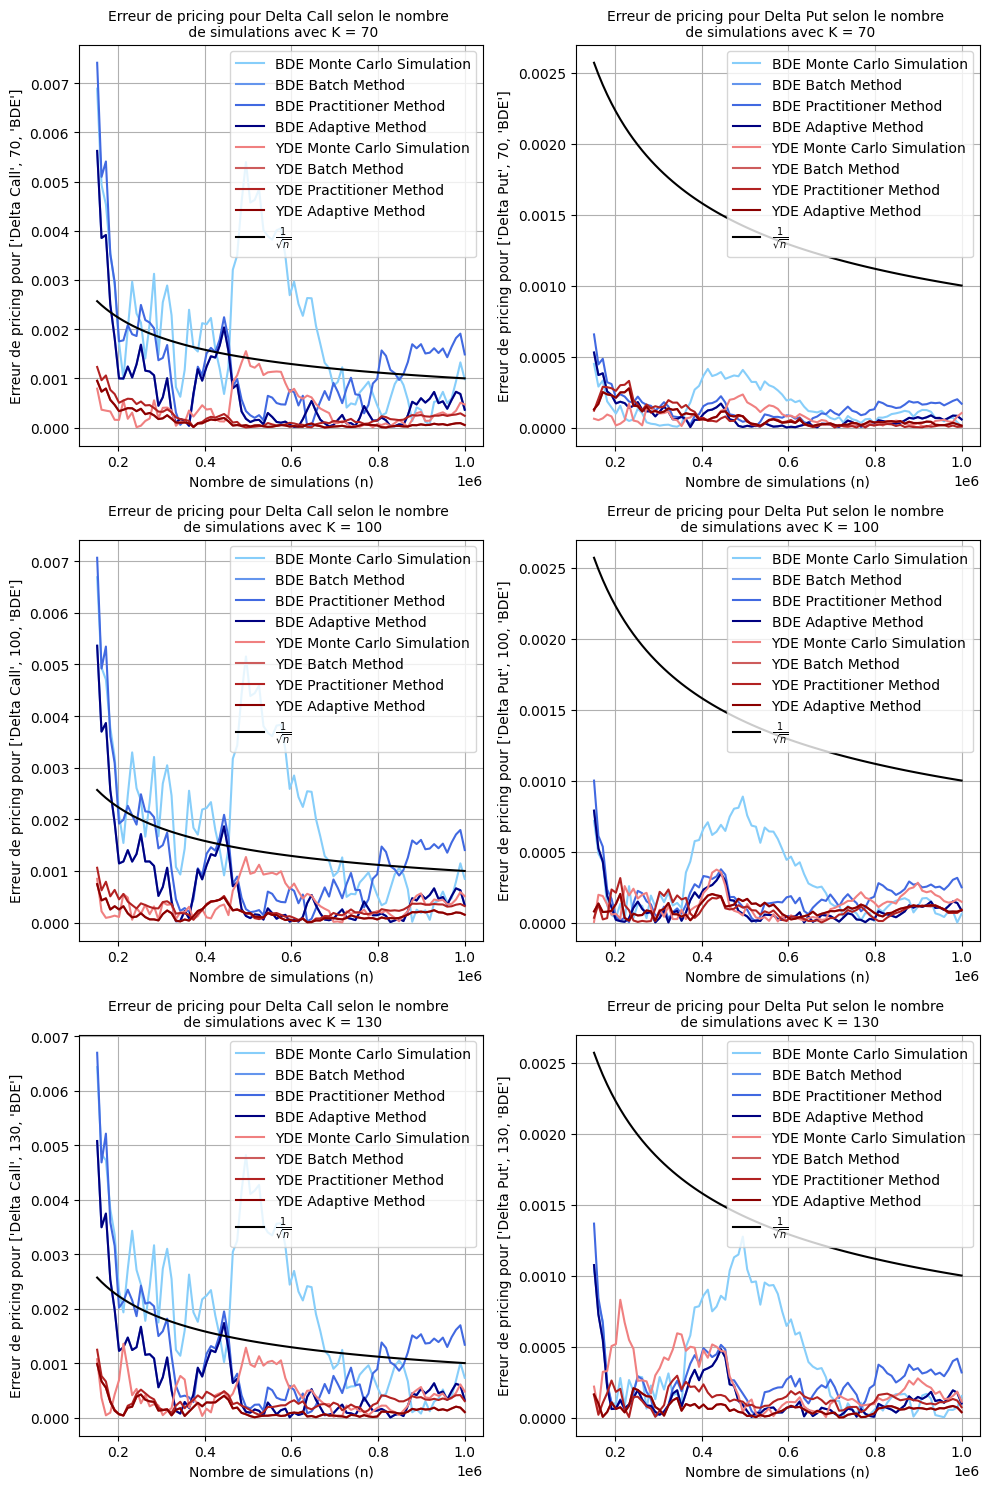

Temps de génération de 1,000,000 prix : 0.03 secondes
Temps de calcul des séries d'estimateurs pour chaque K et chaque fonction de payoff : 3.80 secondes
Temps de traçage : 0.53 secondes
Temps total d'exécution pour une série totale de 4,800 méthodes Monte Carlo : 4.39 secondes


In [61]:
# Nous appliquons une approche pour zoomer uniquement sur les données à la fin de la série,
# afin de supprimer l'effet de la rapide convergence (CV) près de 0.
# La simulation Monte Carlo est relancée, ce qui signifie que les courbes générées ici
# sont différentes de celles tracées précédemment.
beginning = time.time()
print_data_convergence_error_according_to_n(S0_CV, r_CV, sigma_CV, T_CV, K_CV, n_CV, estimator_function_CV, option_type_CV, payoff_function_CV, nb_simu_wanted, zoom=0.15)
end = time.time()
execution_time = end - beginning
print(f"Temps total d'exécution pour une série totale de {16*len(K_CV)*nb_simu_wanted:,} méthodes Monte Carlo : {execution_time:.2f} secondes")

Nous observons les caractéristiques principales suivantes : 
- La convergence de l'erreur suit le taux $0\left(\frac{1}{\sqrt{n}} \right) \to 0 \quad \text{lorsque} \quad n \to \infty$.
- Une meilleure convergence asymptotique pour les méthodes utilisant une réduction de variance par rapport à la méthode Monte Carlo naïve (les tests avec des valeurs de n plus élevées, en réduisant le nombre de points, prennent un peu plus de temps), qui présente une variance élevée.
- Les courbes de la méthode Batch et de la méthode Adaptative se superposent. -> Cela est lié à la convergence asymptotique des résultats des méthodes Batch et Adaptative (pour $k$ grand, $\lambda_k \approx \lambda_{k-1}$ et $\tilde{\lambda}_k = \lambda_k$).
- La convergence s'applique aux deux estimateurs, mais nous constatons toujours que l'estimateur **YDE** est nettement meilleur.

#### 3.3. Représentation graphique des différences entre les prix BS et l'estimateur pour plusieurs strikes

In [67]:
number_simulations = [50000000]  # Nombre de simulations
S0_strikes = 100    # Prix intial de l'actif sous-jacent
r_strikes = 0.05     # Taux sans risque
sigma_strikes = 0.2  # Volatilité
T_strikes = 8     # Maturité
strikes = [strike for strike in range(80, 125, 5)]  # Prix d'exercices
n_strikes = [1000000, 5000000] # Nb de simulation requis
n = 1000000
estimator_function_strikes= [b_d_e_simulation,y_d_e_simulation] # fonctions d'estimation
option_type_strikes = [delta_call,delta_put] # Formule fermée pour nos prix d'options 
payoff_function_strikes = [[payoff_call,payoff_put], [derivative_payoff_call,derivative_payoff_put]] # fonction payoff

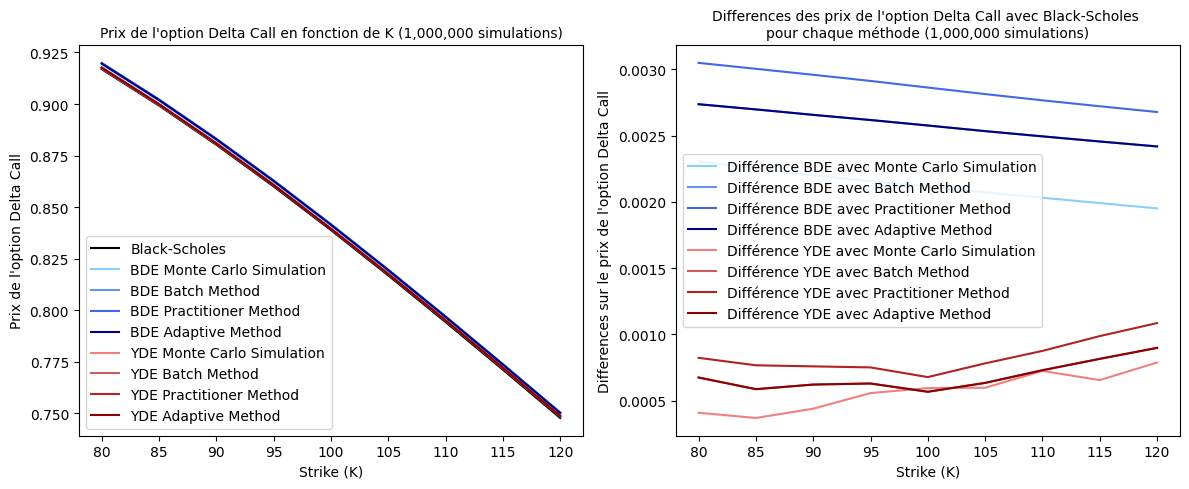

Temps d'exécution pour n égal à 1,000,000: 0.25 secondes


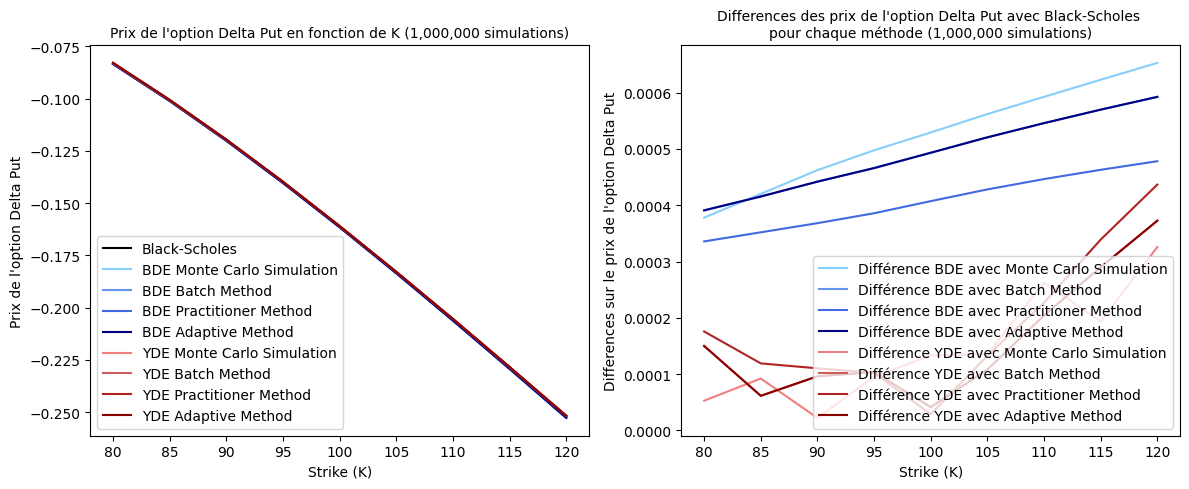

Temps d'exécution pour n égal à 1,000,000: 0.86 secondes


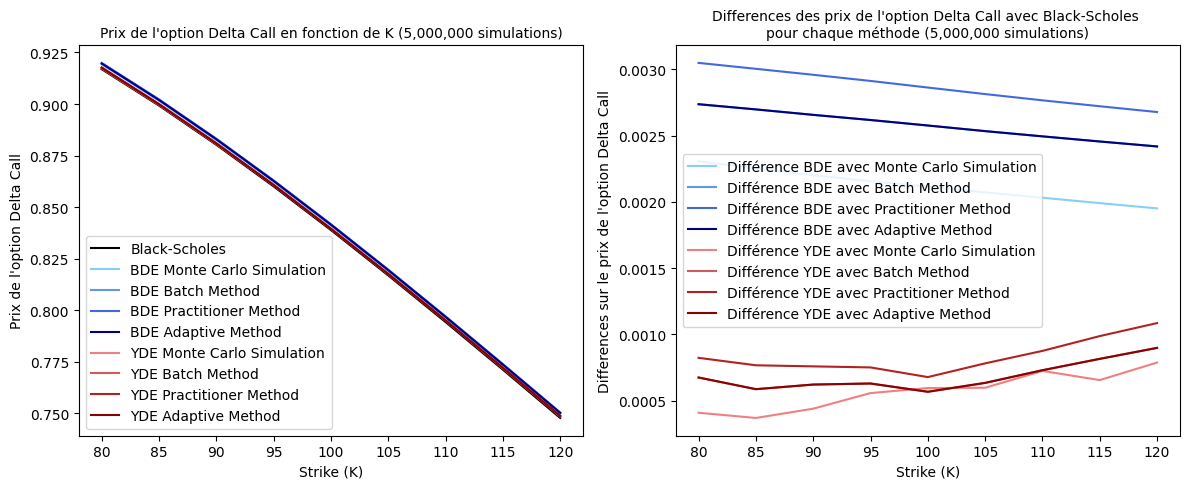

Temps d'exécution pour n égal à 5,000,000: 1.39 secondes


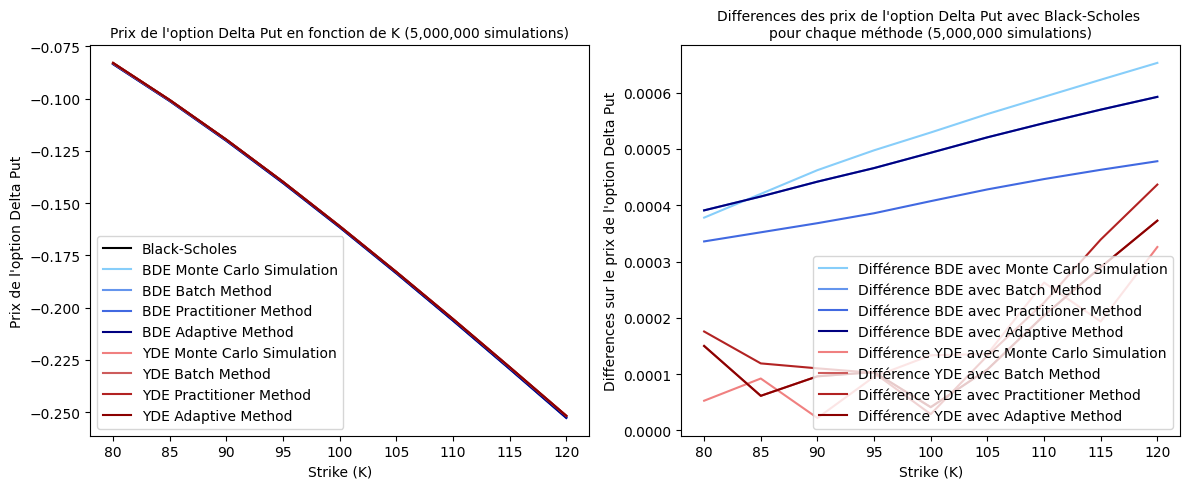

Temps d'exécution pour n égal à 5,000,000: 1.85 secondes


In [68]:
plot_result (S0_strikes,r_strikes,sigma_strikes,T_strikes,strikes,estimator_function_strikes,n_strikes,option_type_strikes,payoff_function_strikes)

Nous avons les principales caractéristiques suivantes : 
- Les erreurs diminuent à mesure que le nombre de simulations augmente, comme déjà montré, avec **YDE** meilleur que **BDE**.
- La méthode utilisant des techniques de réduction de variance donne de meilleures performances d’un point de vue asymptotique et pour toutes les valeurs de strikes.
- Selon la nature de notre option, si elle est largement hors de la monnaie (call) ou dans la monnaie (put), nos erreurs augmentent légèrement.
- Convergence asymptotique des résultats des méthodes Batch et Adaptive (pour $k$ grand, $\lambda_k \approx \lambda_{k-1}$ et $\tilde{\lambda_k} = \lambda_k$).
- Nous confirmons encore la meilleure qualité de l’estimateur **YDE** par rapport à l’estimateur **BDE**.